In [3]:
import gzip
import numpy as np
from matplotlib import pyplot as plot
import time
from tabulate import tabulate
from scipy.special import softmax
import wget

In [4]:
train_images_name = 'train-images-idx3-ubyte'
train_labels_name = 'train-labels-idx1-ubyte'
test_images_name  = 't10k-images-idx3-ubyte'
test_labels_name  = 't10k-labels-idx1-ubyte'
extension = '.gz'


def download_data(name, url='http://yann.lecun.com/exdb/mnist/'):
  wget.download(url + name + extension)


def extract_images(filename):
  filename += extension
  with gzip.open(filename, 'r') as f:
    magic_number = int.from_bytes(f.read(4), 'big')
    number_of_images = int.from_bytes(f.read(4), 'big')
    number_of_rows = int.from_bytes(f.read(4), 'big')
    number_of_columns = int.from_bytes(f.read(4), 'big')
    data = np.frombuffer(f.read(), dtype=np.uint8).reshape(
        (number_of_images, number_of_rows, number_of_columns))
    print('magic number: {}\n\
           number of images: {}\n\
           number of rows: {}\n\
           number of columns: {}'.\
           format(magic_number,
                  number_of_images,
                  number_of_rows,
                  number_of_columns))
    return data


def extract_labels(filename):
  filename += extension
  with gzip.open(filename, 'r') as f:
    magic_number = int.from_bytes(f.read(4), 'big')
    number_of_items = int.from_bytes(f.read(4), 'big')
    data = np.frombuffer(f.read(), dtype=np.uint8)
    print('magic number: {}\n\
           number of items: {}'.\
           format(magic_number,
                  number_of_items))
    return data


def preproc(images, labels):
  images = images / 255.
  labels = np.eye(10)[labels]
  return images, labels


download_data(train_images_name)
download_data(train_labels_name)
download_data(test_images_name)
download_data(test_labels_name)

print('FILE FORMATS information:')
train_images = extract_images(train_images_name)
train_labels = extract_labels(train_labels_name)
test_images = extract_images(test_images_name)
test_labels = extract_labels(test_labels_name)

train_images, train_labels = preproc(train_images, train_labels)
test_images, test_labels = preproc(test_images, test_labels)

FILE FORMATS information:
magic number: 2051
           number of images: 60000
           number of rows: 28
           number of columns: 28
magic number: 2049
           number of items: 60000
magic number: 2051
           number of images: 10000
           number of rows: 28
           number of columns: 28
magic number: 2049
           number of items: 10000


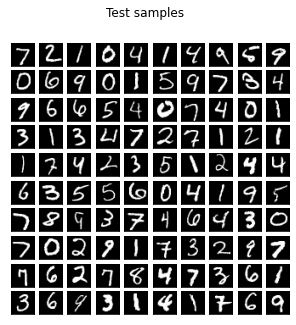

In [5]:
def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10
    
    figsize = (5, 5)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x,
                              figsize=figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap = 'gray')


show_images(test_images, 'Test samples')

In [23]:
class CustomFCNN():
    def __init__(self, layers_lens, \
                 learning_rate, batch_size, num_epochs):
      self.input_len, self.hidden_len, self.out_len = layers_lens
      self.learning_rate = learning_rate
      self.batch_size = batch_size
      self.num_epochs = num_epochs

      # MSRA initialization
      self.W = np.random.normal(0., np.sqrt(2 / self.input_len),
                           [self.input_len, self.hidden_len])
      self.w = np.zeros((1, self.hidden_len))
      self.V = np.random.normal(0., np.sqrt(2 / self.hidden_len),
                           [self.hidden_len, self.out_len])
      self.v = np.zeros((1, self.out_len))


    def relu(self, x):
      return np.maximum(x, 0)


    def drelu(self, x):
      return 1. * (x > 0)


    def forward(self, x):
      s = np.dot(x, self.W) + self.w
      z = self.relu(s)
      t = np.dot(z, self.V) + self.v
      return s, z, t


    def backward(self, x, y, s, z, t, g):
      delta_t = (g - y) / g.shape[0]
      delta_z = np.dot(delta_t, self.V.T)
      delta_s = delta_z * self.drelu(s)

      self.W -= self.learning_rate * np.dot(x.T, delta_s)
      self.V -= self.learning_rate * np.dot(z.T, delta_t)
      self.w -= self.learning_rate * np.sum(delta_s)
      self.v -= self.learning_rate * np.sum(delta_t)


    def get_loss(self, x, y):
      return np.mean(-np.sum(x * np.log(y), axis=1))


    def get_accuracy(self, x, y):
      return np.mean(np.argmax(x, axis=1) == np.argmax(y, axis=1))


    def print_rates(self, rates):
      print(tabulate(rates, headers=['Epoch', 'Loss', 'Accuracy', 'Total time, s'], tablefmt="grid"))


    def train(self, x, y):
      rates = []
      total_time = 0.

      x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])

      X = np.array_split(x, x.shape[0] / self.batch_size)
      Y = np.array_split(y, y.shape[0] / self.batch_size)

      for epoch in range(num_epochs):
        start = time.time()
        for xb, yb in zip(X, Y):
          s, z, t = self.forward(xb)
          g = softmax(t, axis=1)
          self.backward(xb, yb, s, z, t, g)
        end = time.time()
        total_time += end - start

        s, z, t = self.forward(x)
        g = softmax(t, axis=1)
        rates.append([epoch,
                      self.get_loss(y, g),
                      self.get_accuracy(y, g),
                      total_time])
      self.print_rates(rates)


    def inference(self, x, y):
      x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])
      s, z, t = self.forward(x)
      g = softmax(t, axis=1)
      self.print_rates([['test', self.get_loss(y, g), self.get_accuracy(y, g)]])

In [24]:
input_len  = 28 * 28
output_len = 10

learning_rate = 0.1
hidden_neurons_num = 300
batch_size = 64
num_epochs = 20

model = CustomFCNN([input_len, hidden_neurons_num, output_len],
                   learning_rate, batch_size, num_epochs)
model.train(train_images, train_labels)

+---------+-----------+------------+-----------------+
|   Epoch |      Loss |   Accuracy |   Total time, s |
+=========+===========+============+=================+
|       0 | 0.232104  |   0.931383 |         4.06667 |
+---------+-----------+------------+-----------------+
|       1 | 0.160629  |   0.952967 |         8.00773 |
+---------+-----------+------------+-----------------+
|       2 | 0.12391   |   0.964183 |        12.0453  |
+---------+-----------+------------+-----------------+
|       3 | 0.100005  |   0.9711   |        15.9922  |
+---------+-----------+------------+-----------------+
|       4 | 0.0843374 |   0.975783 |        19.941   |
+---------+-----------+------------+-----------------+
|       5 | 0.072019  |   0.9795   |        24.1694  |
+---------+-----------+------------+-----------------+
|       6 | 0.0629646 |   0.9822   |        28.1137  |
+---------+-----------+------------+-----------------+
|       7 | 0.0555913 |   0.9843   |        32.0799  |
+---------

In [25]:
model.inference(test_images, test_labels)

+---------+-----------+------------+
| Epoch   |      Loss |   Accuracy |
+=========+===========+============+
| test    | 0.0665327 |     0.9796 |
+---------+-----------+------------+
